# Surviving the Titanic: the Role of Gatekeepers and Beating the Odds

Prepared by One Hwang

This python notebook serves to fulfill the requirements of 'P2: Investigate a Dataset' for Udacity's Data Analysis program. It analyzes the Titanic's passenger information to characterize the survivors of the RMS Titanic. 

Who survived the Titanic? The ship's officers served as gatekeepers to lifeboats. They followed the captain's instructions to prioritize women, children, and higher class passengers. Thus, passengers had a greater chance of survival if they belonged to the right classifications. However, each gatekeeper interpreted the captain's instructions differently and had varying levels of skill in handing lifeboats. Moreover, could the fittest individuals push their way through crowds to reach the boats? Assertiveness and social support or discouragement from family and other passengers may have also influenced individual abilities to hang onto life.

This notebook aims to answer, **"How much did gatekeepers determine who survived? Who beat the odds to survive the Titanic?"**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/Users/Oneironaut/anaconda2/envs/DAND/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Data Wrangling

### Data-Acquisition

Data were acquired from [Kaggle's 'Titanic: Machine Learning from Disaster'](https://www.kaggle.com/c/titanic/data), which provides records on about 40% of the passengers aboard the Titanic. Moreover, the ship layout and location of cabins was obtained from [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/titanic-deckplans/)

In [2]:
titanic_raw_df = pd.read_csv('titanic-data.csv')

In [3]:
titanic_raw_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
len(titanic_raw_df)

891

### Data Cleaning

#### Remove any duplicate passengers

In [5]:
titanic_df = titanic_raw_df.drop_duplicates(subset=['PassengerId'])

#### Check if there are any NaN's in the data

In [6]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Dropping the NaN's at this point would dramatically reduce our dataset. Although we won't remove the NaN's now, the results above tell us to watch out for NaN's when we analyze Age, Cabin, and Embarked. 

#### Convert data types

If port of embarcation and gender were in binary format, it would be easier to aggregate the information later in the analysis. 

In [7]:
def convert_boolean(col, to_match):
    if col == to_match:
        return 1
    else:
        return 0

In [8]:
titanic_df['is_male'] = titanic_df['Sex'].apply(
    convert_boolean, args=('male',))

In [9]:
ports = titanic_df['Embarked'].dropna().unique()
is_port_cols = ['is_port_S', 'is_port_C', 'is_port_Q']
for pos in range(0,3):
    titanic_df[is_port_cols[pos]] = titanic_df['Embarked'].apply(convert_boolean, args=(ports[pos],))

#### Make meaningful index

In [10]:
len(titanic_df['PassengerId'].unique())

891

Since there are just as many unique PassengerId's as there are rows, PassengerId can serve as index instead of that assigned by Pandas during read_csv. 

In [11]:
titanic_df = titanic_df.set_index('PassengerId')

## Explore Data

In [12]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Overview of sample

In [13]:
titanic_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,is_male,is_port_S,is_port_C,is_port_Q
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.647587,0.722783,0.188552,0.086420
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.477990,0.447876,0.391372,0.281141
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,1.000000,0.000000,0.000000
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000


Highlights from the results above:
- 891 passengers
- 38% of passengers survived
- 65% of passengers were male
- more than 50% were 3rd class 
- average age of 29.7 years 
- at least 50% had no sibling or spouse
- at least 75% had no parents or children
- 75% paid £31 or less for fare
- 72% left from port Southampton

The Titanic killed 1502 of 2224 passengers, and the overall survival rate was 32.5%. This dataset is slightly skewed in favor of those who survived. 

### Differences between survivors and non-survivors

In [14]:
titanic_df.groupby(['Survived']).mean()

,Pclass,Age,SibSp,Parch,Fare,is_male,is_port_S,is_port_C,is_port_Q
Survived,,,,,,,,,
0,2.531876,30.626179,0.553734,0.329690,22.117887,0.852459,0.777778,0.136612,0.085610
1,1.950292,28.343690,0.473684,0.464912,48.395408,0.318713,0.634503,0.271930,0.087719


The results above suggest that the following groups had better chances of survival:
1. First and second passenger classes
2. Women
3. Those who embarked at Cherbourg and not at Southampton
4. Younger people
5. Those without siblings and spouses
6. Those with parents and children
7. Those who paid higher fares

The factors above may be correlated with each other. I.e., more of the women may have been first-class passengers and have had children or parents. 

## Impact of gatekeepers

The gatekeepers who controlled access to the lifeboats prioritized women, higher class passengers, and children. In this section, we explore how much influence they had by examining the extent to which belonging to these categories influenced people's chances for survival. 

### Gender and passenger class

#### Breakdown of survivors and non-survivors according to gender and passenger class

In [15]:
def gender_class_pie(group, startangle, explode):
    index = np.array([
        'Female, 1st class',
        'Female, 2nd class',
        'Female, 3rd class',
        'Male, 1st class',
        'Male, 2nd class',
        'Male, 3rd class',
       ])
    colors=['red', 'pink', 'orange', 'blue', 'green', 'tan']
    group_sizes = group.groupby(['is_male', 'Pclass']).size()
    group_sizes.index = index
    group_sizes.plot.pie(
        autopct='%1.1f%%',
        colors=colors,
        startangle=startangle,
        explode=explode
    )
    plt.axis('equal')
    plt.ylabel('')

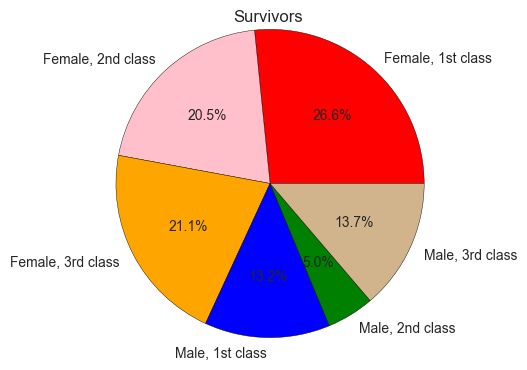

In [16]:
survivors = titanic_df.loc[titanic_df['Survived'] == 1]
explode=(0, 0, 0, 0, 0, 0)
gender_class_pie(survivors, 0, explode)
plt.title('Survivors')

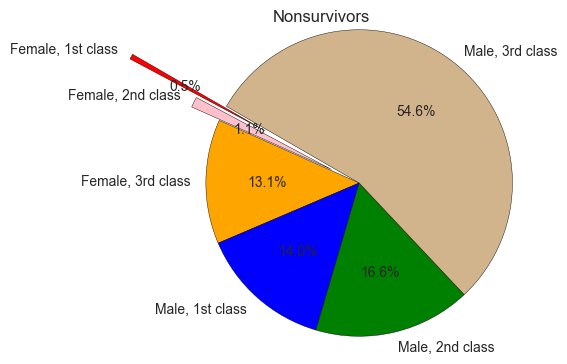

In [17]:
nonsurvivors = titanic_df.loc[titanic_df['Survived'] == 0]
explode=(.7, .2, 0, 0, 0, 0)
gender_class_pie(nonsurvivors, 150, explode)
plt.title('Nonsurvivors')

The charts above show a strong relationship between gender, passenger class, and survival:
- Women comprised 68% of survivors and 15% of non-survivors
- Third class men comprised 14% of survivors and 55% of non-survivors

#### Survival rates for each gender and passenger class

In [18]:
def survival_rate(group):
    total_number = len(group)
    if total_number > 0:
        number_survived = group['Survived'].sum()
        number_died = total_number - number_survived
        percent_survived = (100.*number_survived/total_number)
        #percent_survived = '{0:.2f}%'.format(100.*number_survived/total_number)
    else:
        number_survived = 0.
        number_died = 0.
        percent_survived = 0.
    data = [total_number, number_survived, number_died, percent_survived]
    column_names = ['total number', 'number survived', 'number died', 'percent survived']
    return pd.Series(data, column_names)

In [19]:
# percent of women, men, 1st class, 2nd class, and 3rd class passengers who survived
titanic_df_group = titanic_df.groupby(['is_male', 'Pclass']).apply(survival_rate)
titanic_df_group['percent survived'].unstack()

Pclass,1,2,3
is_male,,,
0,96.808511,92.105263,50.000000
1,36.885246,15.740741,13.544669


The results above show the impact of gatekeepers' preferential treatment of women and higher class passengers:
- Nearly all 1st and 2nd class female passengers survived.
- Nearly all 2nd and 3rd class male passengers died. 

Moreover, they show that both gender and passenger class strongly affected people's chances for survival. Regardless of gender, 1st class passengers were more likely to survive than the 2nd class passengers, and third class passengers had the lowest chances. Regardless of class, women were more likely to survive than men. 

When individuals belonged to one group that received preferential treatment and another group that did not, their chances of survival were more uncertain:
- Half of female third class passengers died
- About a third of first class male passengers survived

### Age

#### Age distribution of all survivors and non-survivors

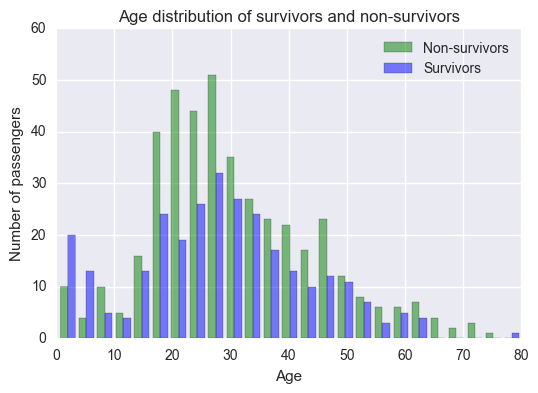

In [20]:
ages_nonsurvivors = nonsurvivors['Age'].dropna()
ages_survivors = survivors['Age'].dropna()
data = [np.array(ages_nonsurvivors), np.array(ages_survivors)]
#ages_df = pd.DataFrame({'Survivors': ages_survivors, 'Non-survivors': ages_nonsurvivors})
colors=['green', 'blue']
labels=['Non-survivors', 'Survivors']
plt.hist(
    data,
    alpha=0.5,
    bins=25,
    histtype='bar',
    color=colors,
    label=labels,
)
plt.title('Age distribution of survivors and non-survivors')
plt.legend(loc='upper right')
plt.xlabel('Age')
plt.ylabel('Number of passengers')

The results above suggest:
- Passengers between ages 0 and 8 had the highest chances of surviving.
- Passengers between ages 16 and 30 had the highest rates of dying.

Perhaps, children were more likely to survive because they tended to be female or belong to a higher passenger class. To rule out this possibility and to confirm that they survived because gatekeepers gave them preference, we investigate the survival rates of children when controlled for gender and passenger class.

#### Survival rates of 2nd and 3rd class males as function of age

In [21]:
bins = [0, 13, titanic_df['Age'].max()]
titanic_3rd_men = titanic_df.loc[(titanic_df['is_male'] == 1) & (titanic_df['Pclass'] != 1)]
titanic_3rd_men_age_indexes = pd.cut(titanic_3rd_men['Age'], bins)
titanic_3rd_men.groupby([titanic_3rd_men_age_indexes]).apply(survival_rate)

,total number,number survived,number died,percent survived
Age,,,,
"(0, 13]",34.0,18.0,16.0,52.941176
"(13, 80]",318.0,35.0,283.0,11.006289


This analysis shows the impact of gatekeepers' preferential treatment of children. Lower class male children under age 13 had better than 53% chance of survival, while all other lower class males had 11% chance of survival. 

### Gatekeepers' individual characteristics

Each gatekeeper had a different skill level in handing life boats and interpreted the captain's instructions to prioritize women and higher class passengers differently. Moreover, [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/titanic-deckplans) diagrams show that the first letter of the cabin number corresponded to the deck and that odd cabin numbers corresponded to the left side of the ship. Since a different gatekeeper was assigned to each deck and each side of the ship, cabin numbers would have reflected which gatekeeper the passengers interacted with. In this section, we explore the survival rates for each deck and side of ship to undercover the impact of gatekeepers' individual characteristics on passengers' survival.

#### Limitations of data

As shown in the analysis below, male, first class passengers was the only group that had sizable number of survivors and non-survivors with cabin data. While the dataset is inadequate for a comprehensive study on gatekeepers, we can gain insights on the extent to which interacting with the right gatekeeper helped first class men to survive.

In [22]:
# To facilitate comparison between survivors and non-survivors, this function separates the group 
# into these subgroups if each subgroup is sizable, i.e. had at least 4 passengers, and returns their sizes
def survivors_vs_nonsurvivors(group):
    total_people = len(group)
    number_survived = group['Survived'].sum()
    number_died = total_people - number_survived
    if number_survived >= 4 and number_died >= 4:
        return group.groupby(['Survived']).size()

In [23]:
# counts of passengers who had cabin data who belonged to classifications with good chances for both surviving and dying
cabin_df = titanic_df.copy().dropna(subset=['Cabin'])
cabin_df['Deck'] = cabin_df['Cabin'].str[:1]
cabin_df.groupby(['is_male', 'Pclass', 'Deck']).apply(survivors_vs_nonsurvivors).dropna()

Survived                0     1
is_male Pclass Deck            
1       1      A      8.0   6.0
               B     12.0   8.0
               C     21.0  11.0
               D      7.0   6.0
               E      7.0   8.0

#### Variations in survival rates across the ship

In [24]:
# odd numbers were on left side of ship
# returns 1 if odd, 0 if even, and '-1' if invalid conversion
def left_side(number):
    number = str(number)
    last_digit = number[-1]
    if str.isdigit(last_digit): 
        return int(last_digit)%2
    return -1 

In [34]:
# survival rates for 1st class men across ship
cabin_df['is_left_side'] = cabin_df['Cabin'].apply(left_side)
cabin_df = cabin_df.drop(cabin_df[cabin_df['is_left_side'] == -1].index)
cabin_male_1st = cabin_df.loc[(cabin_df['is_male'] == 1) & (cabin_df['Pclass'] == 1)]
cabin_male_1st.groupby(['Deck', 'is_left_side'])['Survived'].mean().unstack()

is_left_side,0,1
Deck,,
A,0.444444,0.400000
B,0.333333,0.500000
C,0.428571,0.181818
D,0.125000,1.000000
E,0.555556,0.500000


Variations in survival rates for 1st class men across decks and sides of ship suggest that interacting with the right gatekeeper could significantly improve outcomes. For example, 1st class men had 100% chance of survival if they were on the left side of deck D, and less than 20% chance of survival if they were on the left side of deck C or the right side of deck D. 

Is it possible that this finding is a mere correlation and that the stationing of officers did not matter? Could safety be assured for passengers on the left side of deck D regardless of which officer was stationed there? 

Chances of this happening are small. Although deck C was directly above deck D, its survival rates were very different for first class males. 

The variable that most likely explains this variation is the ship officer who served as gatekeeper. Each gatekeeper intepreted differently the captain's instructions to prioritize women, and the interpretation likely influenced whether 1st class men could get on life boats.

## Beating the odds

Although gatekeepers deterred most lower class passengers and adult males from getting onto lifeboats, a small fraction of these groups still managed to survive and beat the odds. This section explores social interactions with other passengers as variables that explain survival beyond the influence of gatekeepers. Specifically, it examines proximity to 1st class passengers and family.

### Proximity to 1st class passengers

As shown in the table below, 51% of passengers who boarded at Cherbourg were 1st class passengers, and 93% of Queenstown passengers were 3rd class passengers. Did boarding the ship at Cherbourg, which may have increased relationships and associations with 1st class passengers, increase odds for lower class passengers? 

In [26]:
# percent of passengers who boarded at each port who were 1st, 2nd, or 3rd class
pclass_port_counts = titanic_df.groupby(['Embarked', 'Pclass']).size()
total_port_counts = titanic_df.groupby('Embarked').size()
pclass_port_counts.divide(total_port_counts.T).unstack()

Pclass,1,2,3
Embarked,,,
C,0.505952,0.101190,0.392857
Q,0.025974,0.038961,0.935065
S,0.197205,0.254658,0.548137


In [27]:
categories = ['is_male', 'Pclass', 'Embarked']

In [28]:
titanic_df_group = titanic_df.groupby(categories).apply(survival_rate)

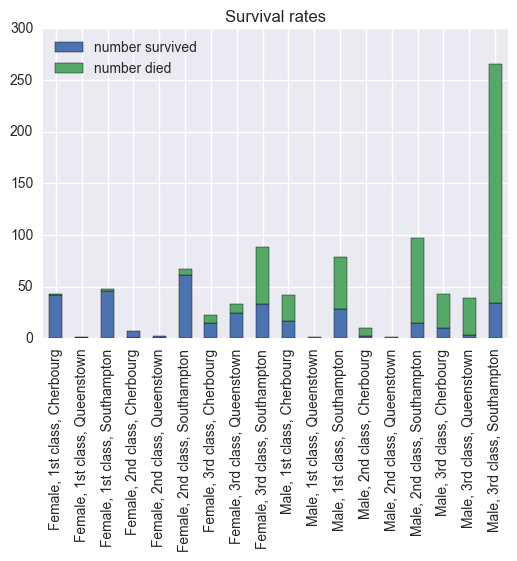

In [29]:
index = np.array([
        'Female, 1st class, Cherbourg',
        'Female, 1st class, Queenstown',
        'Female, 1st class, Southampton',
        'Female, 2nd class, Cherbourg',
        'Female, 2nd class, Queenstown',
        'Female, 2nd class, Southampton',
        'Female, 3rd class, Cherbourg',
        'Female, 3rd class, Queenstown',
        'Female, 3rd class, Southampton',
        'Male, 1st class, Cherbourg',
        'Male, 1st class, Queenstown',
        'Male, 1st class, Southampton',
        'Male, 2nd class, Cherbourg',
        'Male, 2nd class, Queenstown',
        'Male, 2nd class, Southampton',
        'Male, 3rd class, Cherbourg',
        'Male, 3rd class, Queenstown',
        'Male, 3rd class, Southampton',
       ])

titanic_df_group_survival_rates = titanic_df_group.reset_index().set_index(index)
titanic_df_group_survived_died = titanic_df_group_survival_rates[['number survived', 'number died']]
titanic_df_group_survived_died.plot.bar(
    title = 'Survival rates',
    stacked=True)

We notice the following patterns:
- Male, 3rd class passengers who embarked at Southampton was the largest group and created the largest number of deaths
- Males were more likely to survive if they embarked at Cherbourg than if they embarked at Queenstown and or Southampton, regardless of passenger class
- Nearly all female, 1st and 2nd class passengers survived, regardless of port of embarcation
- Female 3rd class passengers were more likely to survive if they embarked at Cherbourg and Queenstown than if they embarked at Southampton

Boarding at Cherbourg increased odds of survival for lower class passenger classes and men. Their proximity to passengers who received preferential treatment may have helped them get onto life boats.

### Family

#### How did the number of family members impact women?

In [30]:
# Number of siblings or spouses
women_sibsp_survival_rate = titanic_df.loc[titanic_df['is_male']==0].groupby(['Pclass','SibSp']).apply(survival_rate)
women_sibsp_survival_rate

total number  number survived  number died  percent survived
Pclass SibSp                                                              
1      0              49.0             48.0          1.0         97.959184
       1              40.0             38.0          2.0         95.000000
       2               3.0              3.0          0.0        100.000000
       3               2.0              2.0          0.0        100.000000
2      0              44.0             41.0          3.0         93.181818
       1              28.0             25.0          3.0         89.285714
       2               3.0              3.0          0.0        100.000000
       3               1.0              1.0          0.0        100.000000
3      0              81.0             48.0         33.0         59.259259
       1              38.0             17.0         21.0         44.736842
       2               7.0              4.0          3.0         57.142857
       3               8.0              1.0          7.0         12.500000
       4               6.0              2.0          4.0         33.333333
       5               1.0              0.0          1.0          0.000000
       8               3.0              0.0          3.0          0.000000

In [31]:
# number of parents or children
women_parch_survival_rate = titanic_df.loc[titanic_df['is_male']==0].groupby(['Pclass','Parch']).apply(survival_rate)
women_parch_survival_rate

total number  number survived  number died  percent survived
Pclass Parch                                                              
1      0              64.0             63.0          1.0         98.437500
       1              17.0             17.0          0.0        100.000000
       2              13.0             11.0          2.0         84.615385
2      0              45.0             40.0          5.0         88.888889
       1              18.0             17.0          1.0         94.444444
       2              11.0             11.0          0.0        100.000000
       3               2.0              2.0          0.0        100.000000
3      0              85.0             50.0         35.0         58.823529
       1              25.0             12.0         13.0         48.000000
       2              25.0              8.0         17.0         32.000000
       3               2.0              1.0          1.0         50.000000
       4               2.0              0.0          2.0          0.000000
       5               4.0              1.0          3.0         25.000000
       6               1.0              0.0          1.0          0.000000

The results suggest that the number of family members did not impact the survival of 1st and 2nd class women. However, traveling alone may have increased chances of survival for 3rd class women.

#### How did the number of family members impact men?

In [32]:
men_sibsp_survival_rate = titanic_df.loc[titanic_df['is_male']==1].groupby(['Pclass','SibSp']).apply(survival_rate)
men_sibsp_survival_rate

total number  number survived  number died  percent survived
Pclass SibSp                                                              
1      0              88.0             29.0         59.0         32.954545
       1              31.0             15.0         16.0         48.387097
       2               2.0              1.0          1.0         50.000000
       3               1.0              0.0          1.0          0.000000
2      0              76.0              9.0         67.0         11.842105
       1              27.0              7.0         20.0         25.925926
       2               5.0              1.0          4.0         20.000000
3      0             270.0             35.0        235.0         12.962963
       1              45.0             10.0         35.0         22.222222
       2               8.0              1.0          7.0         12.500000
       3               4.0              0.0          4.0          0.000000
       4              12.0              1.0         11.0          8.333333
       5               4.0              0.0          4.0          0.000000
       8               4.0              0.0          4.0          0.000000

In [33]:
men_parch_survival_rate = titanic_df.loc[titanic_df['is_male']==1].groupby(['Pclass','Parch']).apply(survival_rate)
men_parch_survival_rate

total number  number survived  number died  percent survived
Pclass Parch                                                              
1      0              99.0             36.0         63.0         36.363636
       1              14.0              4.0         10.0         28.571429
       2               8.0              5.0          3.0         62.500000
       4               1.0              0.0          1.0          0.000000
2      0              89.0              8.0         81.0          8.988764
       1              14.0              7.0          7.0         50.000000
       2               5.0              2.0          3.0         40.000000
3      0             296.0             36.0        260.0         12.162162
       1              30.0              8.0         22.0         26.666667
       2              18.0              3.0         15.0         16.666667
       3               1.0              0.0          1.0          0.000000
       4               1.0              0.0          1.0          0.000000
       5               1.0              0.0          1.0          0.000000

The results above suggest the following:
- Having exactly 1 sibling or spouse significantly increased chances of survival for men for all classes. 
- Having 1 parent or children increased chances for 2nd and 3rd class men, but not for 1st class men.

## Conclusions

Gatekeepers, who prioritized women, children, and 1st class passengers, had considerable influence on who survived. We see their impact through the following:
- Women comprised 68% of survivors, and 15% of non-survivors
- Third class men comprised 14% of survivors and 55% of non-survivors
- Nearly all 1st and 2nd class female passengers survived.
- Nearly all 2nd and 3rd class male passengers died. 
- Lower class males under age 13 had better than 53% chance of survival, while all other lower class males had 11% chance of survival. 

However, each gatekeeper interpreted the captain's instructions differently and had a different level of skill in handling lifeboats. When individuals interacted with the right gatekeeper, they could significantly improve their chances:
- 1st class men had 100% chance of survival if they were on the left side of deck D and less than 20% chance of survival if they were on the left side of deck C or the right side of deck D. 

Moreover, a significant number of lower class passengers and men managed to beat the odds and survive:
- Lower class passengers and men were more likely to survive if they embarked at Cherbourg than at other ports. Cherbourg passengers were predominantly 1st class, and boarding the ship at the same time as 1st class passengers may have strengthened relationships and associations, which improved chances of survival.
- Female 3rd class passengers may have improved their odds by traveling alone while having exactly 1 sibling or spouse significantly improved chances for survival for men for all classes. Family members on ship may have encouraged male passengers to be more assertive in getting onto life boats.